In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split

# SMS Spam Classifier using Logistic Regression

In [2]:
spam_df = pd.read_csv('data/SMSSpamCollection', delimiter='\t',header=None)
spam_df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
print ('Number of spam messages:', spam_df[spam_df[0] == 'spam'][0].count())
print ('Number of ham messages:', spam_df[spam_df[0] == 'ham'][0].count())

Number of spam messages: 747
Number of ham messages: 4825


#### Train/test split

In [4]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(spam_df[1],spam_df[0])

#### Vectorization of X

In [5]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

#### Model Fit and Predictions

In [6]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

In [7]:
for i, prediction in enumerate(predictions[:5]):
    print ('Prediction: {}. Message: {}'.format(prediction, spam_df[1][i]))
    print('=======================================================')

Prediction: ham. Message: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Prediction: ham. Message: Ok lar... Joking wif u oni...
Prediction: ham. Message: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Prediction: spam. Message: U dun say so early hor... U c already then say...
Prediction: ham. Message: Nah I don't think he goes to usf, he lives around here though


## Classification Scoring Metrics

### Confusion Matrix

[[1216    0]
 [  46  131]]


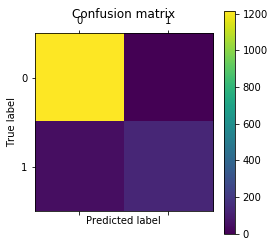

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

confusion_matrix = confusion_matrix(y_test, predictions)
print(confusion_matrix)
plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout
plt.show()

#### Accuracy and Cross-Validation

In [9]:
from sklearn.metrics import accuracy_score
print('Accuracy:', accuracy_score(y_test, predictions))

Accuracy: 0.9669777458722182


In [10]:
scores = cross_val_score(classifier, X_train, y_train, cv=5)
print(np.mean(scores), scores)

0.9578847090507979 [0.95574163 0.95454545 0.95095694 0.97009569 0.95808383]


### Precision vs. Recall

#### Precision: 
* True Positives / (True Positives + False Positives)
* i.e. Of all messages we predicted to be SPAM, what % were actually SPAM?

#### Recall: 
* True Positives / (True Positives + False Negatives)
* i.e. Of all SPAM messages, what % did we correctly identify?

In [11]:
y_train = y_train.astype('category').cat.codes
y_test = y_test.astype('category').cat.codes

precisions = cross_val_score(classifier, X_train, y_train, cv=5, scoring='precision')
print('Precision: ', np.mean(precisions), precisions)
recalls = cross_val_score(classifier, X_train, y_train, cv=5, scoring='recall')
print('Recall: ', np.mean(recalls), recalls)

Precision 0.9926038855659108 [0.98734177 1.         0.98666667 0.98901099 1.        ]
Recalls 0.6964912280701755 [0.68421053 0.66666667 0.64912281 0.78947368 0.69298246]


In [12]:
# Models are sometimes evaluated using the F0.5 and F2 scores,

In [13]:
f1s = cross_val_score(classifier, X_train, y_train, cv=5,
scoring='f1')
print('F1', np.mean(f1s), f1s)

F1 0.8176121137475871 [0.80829016 0.8        0.78306878 0.87804878 0.81865285]


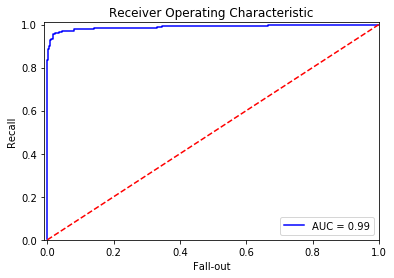

In [14]:
from sklearn.metrics import roc_curve, auc

predictions = classifier.predict_proba(X_test)
false_positive_rate, recall, thresholds = roc_curve(y_test,predictions[:, 1])
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' %
roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score

pipeline = Pipeline([
 ('vect', TfidfVectorizer(stop_words='english')),
 ('clf', LogisticRegression())
])
parameters = {
 'vect__max_df': (0.25, 0.5, 0.75),
 'vect__stop_words': ('english', None),
 'vect__max_features': (2500, 5000, 10000, None),
 'vect__ngram_range': ((1, 1), (1, 2)),
 'vect__use_idf': (True, False),
 'vect__norm': ('l1', 'l2'),
 'clf__penalty': ('l1', 'l2'),
 'clf__C': (0.01, 0.1, 1, 10),
}

In [16]:
df = pd.read_csv('data/SMSSpamCollection', delimiter='\t',header=None)
X, y, = df[1], df[0]
X_train, X_test, y_train, y_test = train_test_split(X, y)

# grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1,verbose=1, scoring='accuracy', cv=3)
# grid_search.fit(X_train, y_train)

import pickle
# Save dict object through pickle
# pickle_out = open('grid_search.pickle','wb')
# pickle.dump(grid_search, pickle_out)
# pickle_out.close

# Code to re-open pickled dictionary
pickle_in = open('grid_search.pickle','rb')
grid_search = pickle.load(pickle_in)

print('Best score: %0.3f' % grid_search.best_score_)
print('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))
    predictions = grid_search.predict(X_test)
print('Accuracy:', accuracy_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions,labels=['ham', 'spam'],pos_label='spam'))
print('Recall:', recall_score(y_test, predictions,labels=['ham', 'spam'],pos_label='spam'))

Fitting 3 folds for each of 1536 candidates, totalling 4608 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 4608 out of 4608 | elapsed: 14.1min finished


Best score: 0.982
Best parameters set:
	clf__C: 10
	clf__penalty: 'l2'
	vect__max_df: 0.5
	vect__max_features: 10000
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__stop_words: None
	vect__use_idf: True
Accuracy: 0.9892318736539842
Precision: 0.9938271604938271
Recall: 0.92


## Multi-Class Classification

In [18]:
df = pd.read_csv('data/train.tsv', header=0,delimiter='\t')
df.count()

PhraseId      156060
SentenceId    156060
Phrase        156060
Sentiment     156060
dtype: int64

In [22]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [24]:
df[df['SentenceId']==8544]

,PhraseId,SentenceId,Phrase,Sentiment
156039,156040,8544,"The film is darkly atmospheric , with Herrmann...",2
156040,156041,8544,"is darkly atmospheric , with Herrmann quietly ...",2
156041,156042,8544,"is darkly atmospheric , with Herrmann quietly ...",2
156042,156043,8544,"is darkly atmospheric ,",2
156043,156044,8544,is darkly atmospheric,3
156044,156045,8544,with Herrmann quietly suggesting the sadness a...,2
156045,156046,8544,Herrmann quietly suggesting the sadness and ob...,2
156046,156047,8544,Herrmann,2
156047,156048,8544,quietly suggesting the sadness and obsession b...,1
156048,156049,8544,suggesting the sadness and obsession beneath H...,2


In [25]:
df['Sentiment'].describe()

count    156060.000000
mean          2.063578
std           0.893832
min           0.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: Sentiment, dtype: float64

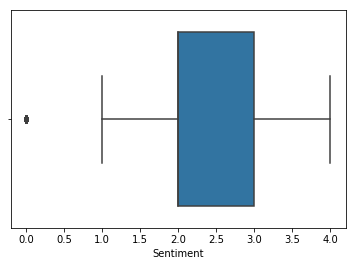

In [28]:
import seaborn as sns
sns.boxplot(df['Sentiment'])
plt.show()

In [29]:
df['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

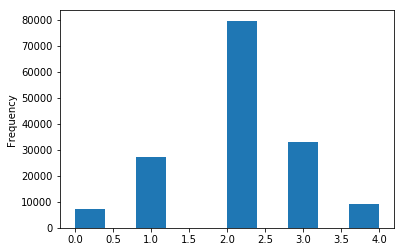

In [33]:
df['Sentiment'].plot(kind='hist')

In [34]:
df['Sentiment'].value_counts()/df['Sentiment'].count()

2    0.509945
3    0.210989
1    0.174760
4    0.058990
0    0.045316
Name: Sentiment, dtype: float64

In [57]:
pipeline = Pipeline(
    [('vect', TfidfVectorizer(stop_words='english')),
     ('clf',LogisticRegression())])

parameters = {
    'vect__max_df': (0.25, 0.5),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'vect__use_idf': (True, False),
    'clf__C': (0.1, 1, 10),}

df = pd.read_csv('data/train.tsv', header=0, delimiter='\t')
X, y = df['Phrase'],df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y)

# grid_search2 = GridSearchCV(pipeline, parameters, n_jobs=3,verbose=1, scoring='accuracy')
# grid_search2.fit(X_train, y_train)

# # Save dict object through pickle
# pickle_out = open('grid_search2.pickle','wb')
# pickle.dump(grid_search2, pickle_out)
# pickle_out.close

# Code to re-open pickled dictionary
pickle_in = open('grid_search2.pickle','rb')
grid_search2 = pickle.load(pickle_in)

print('Best score: %0.3f' % grid_search2.best_score_)
print('Best parameters set:')
best_parameters = grid_search2.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:  5.0min finished


Best score: 0.638
Best parameters set:
	clf__C: 10
	vect__max_df: 0.25
	vect__ngram_range: (1, 2)
	vect__use_idf: False


In [89]:
from sklearn.metrics import classification_report

predictions = grid_search2.predict(X_test)
print('Accuracy:', accuracy_score(y_test, predictions))

Accuracy: 0.6537229270793284


In [90]:
# print('Confusion Matrix:', confusion_matrix(y_test, predictions))
print('Classification Report:', classification_report(y_test,predictions))

Classification Report:              precision    recall  f1-score   support

          0       0.52      0.35      0.42      1709
          1       0.56      0.48      0.52      6737
          2       0.72      0.82      0.77     19903
          3       0.57      0.52      0.55      8310
          4       0.57      0.40      0.47      2356

avg / total       0.64      0.65      0.64     39015

